# Mandatory Assignment 2: Sampling Customers

**This is the second of three mandatory assignments to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

#### Practical info
- **The assignment is to be done individually. You are under no circumstances allowed to collaborate with anyone on solving the exercises (cf. the full policy on this on the course website)**
- **You must hand in one Jupyter notebook (this notebook) with your solution**
- **The hand-in of the notebook is due 2019-11-10, 23:59 on DTU Inside**

#### Your solution
- **Your solution should be in Python**
- **You may use more cells than the provided ones for your answers**
- **You should not remove the problem statements**
- **Your notebook should be runnable, i.e., clicking [>>] in Jupyter should generate the result that you want to be assessed**

---
## Introduction
When computing group aggregates from a sample, simple random sampling does not give good results. Instead, a representative sample can be obtained by storing each record seen from a sample of the elements we group by. 

In this assignment you should implement this sampling method on a stream of customer spendings.

### Example
Suppose you are sampling from a stream of customer spendings. Each element of the stream consists of a customer ID and an amount. For example:

`123e4567-e89b-12d3-a456-426655440000 29.99`

To obtain a representative sample, you should sample some customer IDs and make sure that every occurrence of the sampled customer IDs are in your final sample. For example, if the customer ID `123e4567-e89b-12d3-a456-426655440000` is among the sampled customer IDs, every element with this ID should be in your sample. 

## Reading the stream
The following code reads a remote file line by line. It is wrapped in a generator to make it easier to extend. You should design your algorithm to read from the generator as a stream. You may extend or modify this to fit your requirements.

In [1]:
url = 'https://files.dtu.dk/fss/public/link/public/stream/read/spending?linkToken=wkMPLdtDDyvQQw8o&itemName=spending'

Note:  
Changed stream to separate id/value pairs and to return $n$ objects instead of $n+1$

In [2]:
import urllib

def stream(n):
    i = 0
    with urllib.request.urlopen(url) as f:
        for line in f:
            if i == n:
                break
            element = line.rstrip().decode("utf-8").split(' ')
            yield element
            i += 1

In [3]:
STREAM_SIZE = 10
customer_stream = stream(STREAM_SIZE)

In [4]:
next(customer_stream)

['0051a824-11a1-41e8-9023-694e75b92e41', '44.26']

## Exercise 1
Implement an algorithm that computes a sample from the stream. The sample must be representative of customers, i.e., you should be able to answer group aggregate questions from it.

The sample size should be approximately 10% of the number of elements read from the stream.

It is important that your algorithm is a streaming algorithm. This means that your algorithm should update the sample every time an element from the stream is processed, and you should also only process the stream once.

### Hints
Hint 1: Since simple random sampling is not a good idea, you should not use the reservoir sampling algorithm.

Hint 2: The sample does not have to be exactly $k$ elements.

Hint 3: You should use a hash function and the fact that it can be used to uniformly map elements from a large universe to a smaller domain. Murmurhash3 (`mmh3`) is a suitable hash function from strings to integers for this.

### Solution
+ Hash customer IDs to $\frac{1}{10\%} = 10$ bins.
+ Keep the first bin as out sample

In [5]:
import mmh3
from tqdm import tqdm_notebook as tqdm # for nice progress bars on long streams

In [17]:
n_sample_stream = int(1e6)
sample_stream = stream(n_sample_stream)
sample = []
for c in tqdm(sample_stream, total=n_sample_stream):
    hash_bin = mmh3.hash(c[0]) % 10
    if hash_bin == 0:
        sample.append(c)
        
print(f'Sample Size: {len(sample)}/{n_sample_stream} ({round(len(sample)/n_sample_stream*100,2)}%)')


Sample Size: 91926/1000000 (9.19%)


## Exercise 2
Use the sample obtained in the previous exercise to answer the following question.

- What is the average spending per customer?

In [18]:
totals_spending = {cid: round(sum([float(t[1])  for t in sample if t[0]==cid]),2) for cid in set(list(zip(*sample))[0])}
avg_spend_per_customer = round(sum(totals_spending.values()) / len(totals_spending.keys()), 2)
print(f'The average customer spent {avg_spend_per_customer}')

The average customer spent 137071.6


## Exercise 3
Explain why simple random sampling would not give as good an answer to the question in exercise 2 as your new algorithm does.

Hint: Look at the distribution of amounts for some customer in your sample.

### Explanation
With reservoir/random sampling, approximately 10% of the transactions from each customer would be included in the sample. Looking at the distribution of transaction amounts for a single customer, it appears to be approximately uniform, thus having a very large variance. Randomly sampling 10% of this distribution, it would be very likely to get an unrepresentative sample. Multiplying the sum of the sample by 10 to approximate the total would even further throw off the estimate. By sampling 10% of customers instead and including all transactions for each customer, we trade our assumption of equal value transactions for an assumption that all customers are similar. Looking at the histogram of total amount purchased per customer, this appears to be a more valid assumption as the variance is smaller. In this case, we are also estimating the total directly instead of multiplying which will help minimize estimation error.

In [8]:
import matplotlib.pyplot as plt

In [9]:
customer_a = [t[1] for t in sample if t[0]==sample[0][0]]

Text(0.5, 1.0, 'Distribution of Transaction Amounts for a Sample Customer')

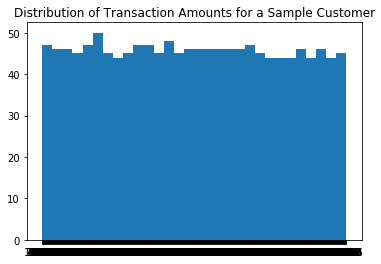

In [14]:
%matplotlib inline
plt.hist(customer_a, 30)
plt.title('Distribution of Transaction Amounts for a Sample Customer')

Text(0.5, 1.0, 'Distribution of total spending per customer')

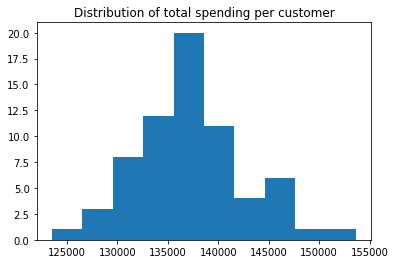

In [15]:
%matplotlib inline
plt.hist(totals_spending.values())
plt.title('Distribution of total spending per customer')